In [66]:
import sys
sys.path.append('..')
import os
from os.path import join
import numpy as np
import pandas as pd

from nilearn.datasets.utils import _uncompress_file, _fetch_file

import seaborn as sns
sns.set_style("whitegrid")

In [2]:
order = pd.read_csv('../data_in/MIST122_relabeled.tsv', sep='\t').iloc[:, 1:]

def _get_paths(phenotypic, atlas, timeseries_dir):
    timeseries = []
    IDs_subject = []
    diagnosis = []
    subject_ids = phenotypic['SUB_ID']
    mean_fd = []
    num_fd = []
    perc_fd = []
    site = []
    for index, subject_id in enumerate(subject_ids):
        this_pheno = phenotypic[phenotypic['SUB_ID'] == subject_id]
        this_timeseries = join(timeseries_dir, atlas,
                               str(subject_id) + '_timeseries.txt')
        if os.path.exists(this_timeseries):

            ts = np.loadtxt(this_timeseries)
            #reorder columns in ts based on order['index']
            ts = ts[:, order['index'].values-1]

            timeseries.append(ts)
            IDs_subject.append(subject_id)
            diagnosis.append(this_pheno['DX_GROUP'].values[0])
            mean_fd.append(this_pheno['func_mean_fd'].values[0])
            num_fd.append(this_pheno['func_num_fd'].values[0])
            perc_fd.append(this_pheno['func_perc_fd'].values[0])
            site.append(this_pheno['SITE_ID'].values[0])
    return timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site

In [3]:
phenotypic = pd.read_csv('../../connattractor/notebooks/abide_data/Phenotypic_V1_0b_preprocessed1.csv').iloc[:,2:]
timeseries, diagnosis, IDs_subject, mean_fd, num_fd, perc_fd, site = _get_paths(phenotypic, "BASC/networks", '../../connattractor/notebooks/abide_data/')
sites, site_int = np.unique(site, return_inverse=True)

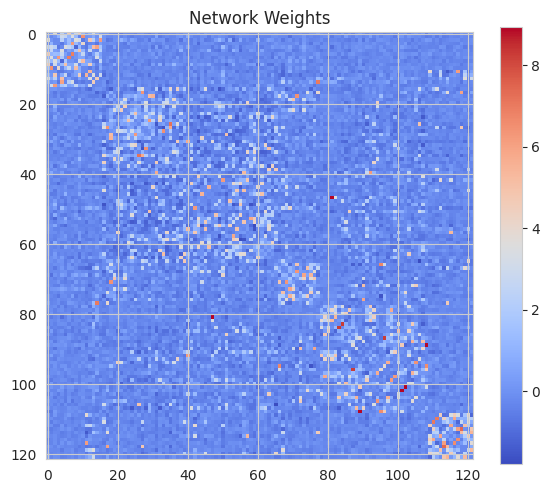

In [4]:
from nilearn.connectome import ConnectivityMeasure
from connattractor import network

diag_nyu = np.array(diagnosis)[np.array(site)=='NYU']

idxs = np.where((diag_nyu==1) | (diag_nyu==2))[0]

connections = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
tmp = [timeseries[i] for i in idxs]
connections.fit_transform(tmp)

mtx = connections.mean_
hopnet = network.Hopfield(mtx, scale=True)
hopnet.plot_weights()

In [5]:
np.unique(diag_nyu, return_counts=True)

(array([1, 2]), array([74, 98]))

In [6]:
idx_ctr = np.where(diag_nyu==1)[0]
idx_path = np.where(diag_nyu==2)[0]

In [7]:
ts_idx = list(idx_ctr) + list(idx_path)
timeseries = [value for index, value in enumerate(timeseries) if index in ts_idx]

In [8]:
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
import connattractor.statedynamics as sd

_threshold_ = 0

hopnet.beta = 0.044 # 4 states for group level connectome

_standardize_ts = True
_standardize_act = True

_TR_ = 3.0 #sec

# statedict is now group-level
statedict = []
meanacts = []
statelabels = []

for ts in tqdm(timeseries):
    # standardize timeseries
    ts = pd.DataFrame(data=ts)

    columns = ts.columns
    if _standardize_ts:
        ts = pd.DataFrame(StandardScaler().fit_transform(ts), columns=columns)

    # get all subject-level attractor states activations:
    attractor_states = sd.get_attractors_per_timesample(ts, hopnet)

    statelabel, statedict = sd.label_att_states(attractor_states, statedict)

    meanacts.append(sd.mean_state_activation(statedict, statelabel, ts, _standardize_act))
    statelabels.append(statelabel)
    
print('number of states:', len(statedict))

  0%|          | 0/172 [00:00<?, ?it/s]

number of states: 4


In [9]:
from connattractor.statedynamics import StateDynamics

statecontainer = StateDynamics()
statecontainer.read_meanactivation(meanacts)

In [11]:
import pickle

filename = '../data_out/abide/abide_meanacts.pckl'

with open(filename, 'wb') as f:
    pickle.dump(meanacts, f)

## Stats

In [12]:
labels_ctr = [arr for i, arr in enumerate(statelabels) if i in idx_ctr]
labels_path = [arr for i, arr in enumerate(statelabels) if i in idx_path]

In [13]:
# sort the activations according to group and state
act_ctr = {key: [] for key in range(len(statedict))}
act_path = {key: [] for key in range(len(statedict))}

for idx, sub_ts in enumerate(timeseries):
    if idx in idx_ctr:
        for idx_label, label in enumerate(statelabels[idx]):
            act_ctr[label].append(sub_ts[idx_label])
    elif idx in idx_path:
        for idx_label, label in enumerate(statelabels[idx]):
            act_path[label].append(sub_ts[idx_label])
    else:
        print(idx)
    

In [14]:
# calc mean acts
mean_act_ctr = {}
mean_act_path = {}

for state, acts in act_ctr.items():
    mean_act_ctr[state] = np.mean(acts, axis=0)
    
for state, acts in act_path.items():
    mean_act_path[state] = np.mean(acts, axis=0)

In [15]:
from collections import Counter

# ts have different lengths, shuffle values manually
flattened_list = [item for sublist in statelabels for item in sublist]

frequency = dict(Counter(flattened_list))

# do this group specific
labels = list(frequency.keys())
freq = list(frequency.values())
freq = [s/sum(freq) for s in freq]
freq

[0.40894483128012854,
 0.09252811997857525,
 0.09510578468130691,
 0.4034212640599893]

In [63]:
import random 

def rand_label():
    return random.choices(labels, freq)[0]

def workhorse(seed):
    # cast from int64 to int to suppress dep warning
    random.seed(int(seed))
    timeseries_shuffled = timeseries.copy()
    
    act_ctr = {key: [] for key in range(len(statedict))}
    act_path = {key: [] for key in range(len(statedict))}
    
    for idx, sub_ts in enumerate(timeseries_shuffled):
        if idx in idx_ctr:
            for idx_label, label in enumerate(statelabels[idx]):
                act_ctr[rand_label()].append(sub_ts[idx_label])
        elif idx in idx_path:
            for idx_label, label in enumerate(statelabels[idx]):
                act_path[rand_label()].append(sub_ts[idx_label])
                
    mean_act_diff = {}

    for state, acts in act_ctr.items():
        mean_act_diff[state] = np.mean(acts, axis=0) - np.mean(act_path[state], axis = 0)
        
    return mean_act_diff

In [65]:
from joblib import Parallel, delayed

n_perm = 1000

rand = np.random.default_rng(42)
# produces int64, which will be deprecated as a seed
seeds = rand.integers(0, np.iinfo(int).max, n_perm)

results = Parallel(n_jobs=-1)(delayed(workhorse)(seed) for seed in seeds)



In [33]:
# unpack the results
states_null_dist = {}

for idx, res in enumerate(results):
    if idx == 0:
        for state, acts in res.items():
            states_null_dist[state] = acts
            
    else:
        for state, acts in res.items():
            states_null_dist[state] = np.vstack([states_null_dist[state], acts]) 

# vis

In [35]:
# actual stats
alpha = 5
alpha_bnfr = 0.0102 # 5 /( 4 states and 122 regions)

sig_differences = {key: [] for key in range(len(statedict))}
act_differences = {key: [] for key in range(len(statedict))}

for state, null_dist in states_null_dist.items():
    actual_difference = mean_act_ctr[state] - mean_act_path[state]
    sig_difference = actual_difference.copy()
    for reg in range(np.shape(null_dist)[1]):
        alpha_threshold = np.percentile(null_dist[:, reg], 100 - alpha_bnfr)
        # if it doesnt pass the threshold, set to 0
        if actual_difference[reg] < alpha_threshold:
            sig_difference[reg] = 0
    sig_differences[state] = sig_difference
    act_differences[state] = actual_difference

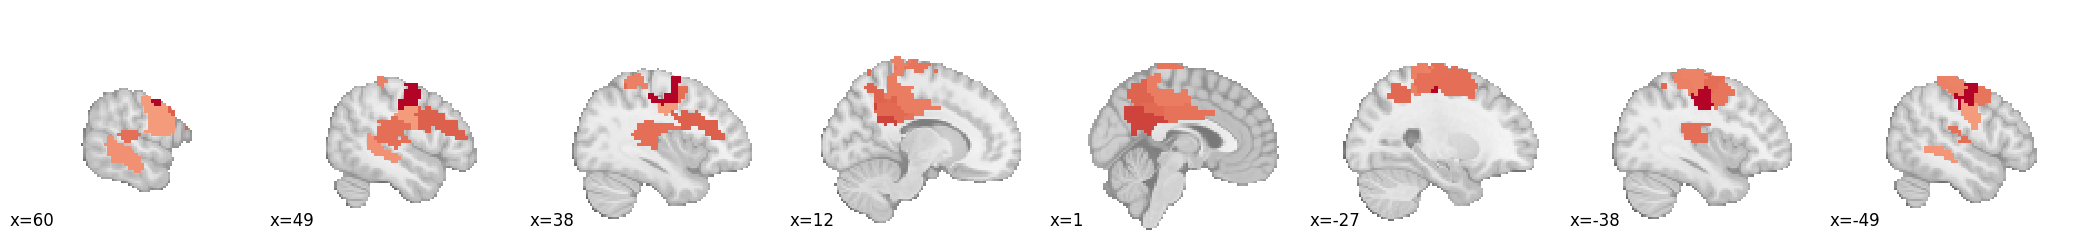

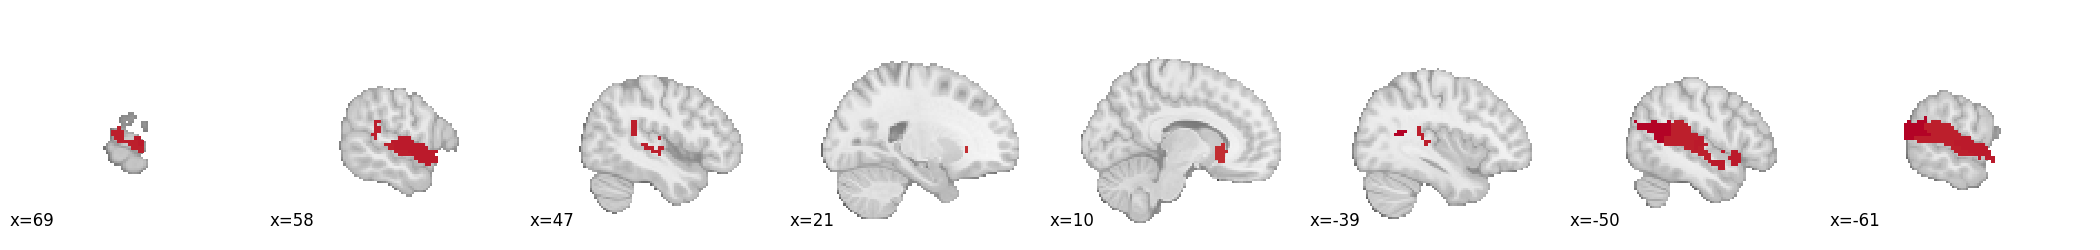

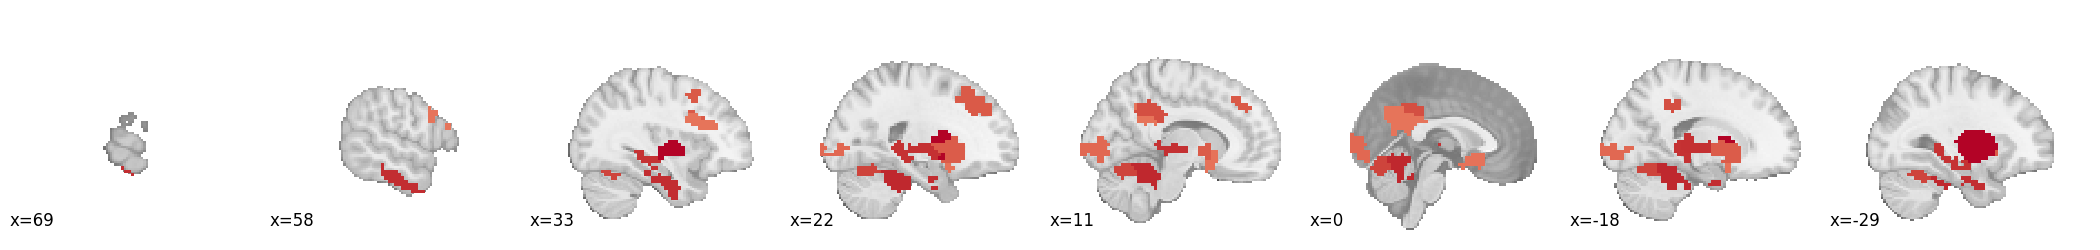

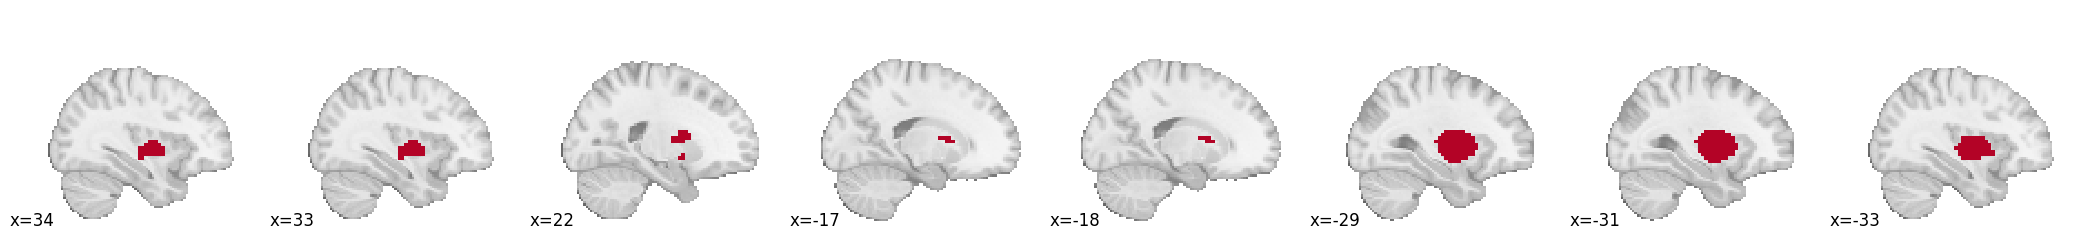

In [39]:
# manually select slices to plot sig meanacts
import matplotlib.cm as cm
import nilearn.plotting as plotting
import matplotlib.pyplot as plt 

roi_kwargs = {
    'display_mode': 'x',
    'cmap': cm.coolwarm,
    'cut_coords': (8),
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False
}

for state in range(len(statedict)):
    plotting.plot_stat_map(network.State(sig_differences[state]).to_Nifti1Image(), **roi_kwargs)
    plt.show()

In [40]:
state_slices = {
    0: [1],
    1: [-50],
    2: [1],
    3: [-31]
}

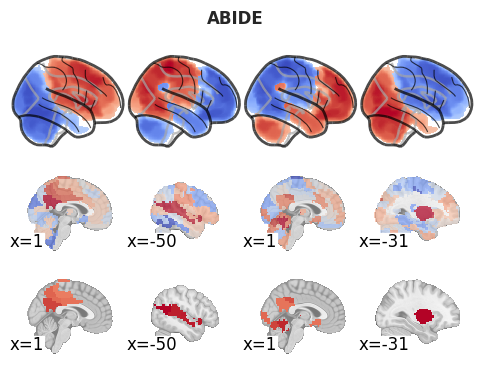

In [42]:

glassbrains_kwargs = {
            'display_mode': 'r',
            'colorbar': False,
            'plot_abs': False,
            'cmap': cm.coolwarm,
            }

roi_kwargs = {
    'display_mode': 'x',
    'cmap': cm.coolwarm,
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False
}

roi_kwargs_empty = {
    'display_mode': 'x',
    'cmap': 'light-gray',
    'cut_coords': [20],
    'colorbar': False,
    'threshold': 0,
    'draw_cross': False,
    'alpha': 0.2,
    'dim': 10
}


fig, axes = plt.subplots(3, 4, figsize=(6, 4), gridspec_kw = {'wspace':0, 'hspace':0})

for state in range(len(statedict)):
    network.State(statedict[state]).plot(**glassbrains_kwargs, axes=axes[0, state])

    #network.State(actual_difference).plot(**glassbrains_kwargs, axes=axes[1, state])
    plotting.plot_roi(network.State(act_differences[state]).to_Nifti1Image(), 
                                      cut_coords=state_slices[state], **roi_kwargs, axes=axes[1, state])
    #network.State(sig_difference).plot(**glassbrains_kwargs, axes=axes[2, state])
    if any(reg != 0 for reg in sig_differences[state]):
        plotting.plot_stat_map(network.State(sig_differences[state]).to_Nifti1Image(), 
                               cut_coords=state_slices[state], **roi_kwargs, axes=axes[2, state])

    else:
        plotting.plot_stat_map(network.State(np.zeros(122)).to_Nifti1Image(), **roi_kwargs_empty, axes=axes[2, state])


fig.suptitle("ABIDE", fontsize=12, fontweight='bold')

plt.subplots_adjust(top=0.8)
plt.savefig('../data_out/fig/ABIDE_state_analysis.pdf')
plt.show()

## Plots for compound figure

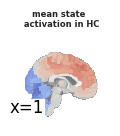

In [43]:
#plt.rcParams['figure.figsize'] = (2, 2)

fig = plt.figure(figsize=(1, 1))

state = 0

roi_kwargs = {
    'display_mode': 'x',
    'cmap': cm.coolwarm,
    'cut_coords': [1],
    'colorbar': False,
    'vmax': 0.5,
    'vmin': -0.5,
    'threshold': 0,
    'draw_cross': False,
}

plotting.plot_roi(network.State(mean_act_ctr[state]).to_Nifti1Image(), figure=fig, **roi_kwargs)
plt.title('mean state \n activation in HC', size=6,fontweight="bold")
plt.savefig('../data_out/fig/ABIDE_meanact_slice_hc_single_state.pdf')
plt.show()

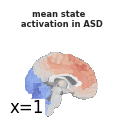

In [44]:
fig = plt.figure(figsize=(1, 1))

plotting.plot_roi(network.State(mean_act_path[state]).to_Nifti1Image(), figure=fig, **roi_kwargs)
plt.title('mean state \n activation in ASD', size=6,fontweight="bold")
plt.savefig('../data_out/fig/ABIDE_meanact_slice_asd_single_state.pdf')
plt.show()

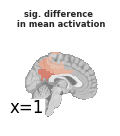

In [45]:
state = 0

roi_kwargs.update({
    'vmax': 0.08,
    'vmin': 0
})

fig = plt.figure(figsize=(1, 1))

plotting.plot_roi(network.State(sig_differences[state]).to_Nifti1Image(), figure=fig, **roi_kwargs)

plt.title('sig. difference \n in mean activation', size=6,fontweight="bold")
plt.savefig('../data_out/fig/ABIDE_meanact_diff_sig_single_state.pdf')
plt.show()

### saving stuff for embeddings/projections

In [46]:
import pickle

filename = '../data_out/abide/abide_meanact_sig_diff.pckl'

with open(filename, 'wb') as f:
    pickle.dump(sig_differences, f)

In [47]:
filename = '../data_out/abide/abide_connectome.pckl'

with open(filename, 'wb') as f:
    pickle.dump(mtx, f)

In [48]:
filename = '../data_out/abide/abide_statelabels.pckl'

with open(filename, 'wb') as f:
    pickle.dump(statelabels, f)
